# Installing and importing Dependencies

In [1]:
%pip install yfinance
%pip install pandas_ta
%pip install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import yfinance as yf
from ta.trend import ADXIndicator
import pandas_ta as pd_ta
import torch
import gym
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch.nn as nn
from torch.distributions import Categorical as Cat
from torch.optim import Adam as adam
gpu = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Environment

## Defining Indicators for the observation

In [3]:
def data_ops(data):
  data.reset_index()
  data.ta.macd(close = 'Close', fast = 12, slow = 26, signal=10, append=True)
  data.ta.rsi(close='Close', length=10, append=True)
  data['TP'] = (data['High'] + data['Low'] + data['Close'])
  data['CCI'] = (data['TP'] - data['TP'].rolling(10).mean()) / (0.015 * data['TP'].rolling(10).std())
  data['Adj Open'] = data.Open * data['Adj Close']/data['Close']
  data['Adj High'] = data.High * data['Adj Close']/data['Close']
  data['Adj Low'] = data.Low * data['Adj Close']/data['Close']
  adxI = ADXIndicator(data['Adj High'], data['Adj Low'], data['Adj Close'], 10, False)
  data['ADX'] = adxI.adx()
  data.dropna()
  req_col = ['Open', 'High', 'Close', 'Low', 'Adj Close', 'MACDs_12_26_10', 'RSI_10', 'CCI', 'ADX']
  new_data = data[req_col]
  return new_data.dropna()

## Defining the environment

In [4]:
class StockTradingEnv:
  def __init__(self, stock = 'DOGE-USD', start = '2022-10-15', end='2022-11-30', period='15m', start_balance=[1000, 1000], step_val = 4):
    data = yf.download(stock, start = start, end = end, interval = period)
    self.data = data_ops(data)
    self.start_bal = start_balance
    self.step_val = step_val
    self.step_bal = [(start_balance[0]/self.data.iloc[0]['Adj Close']), start_balance[1]]
  
  def load_obs(self):
    obs = [None] * 7
    if self.flag0 == 0:
      obs[0] = self.start_bal[1]
      obs[1] = self.start_bal[0]/self.data.iloc[0]['Open']
    else:
      obs[0] = self.step_bal[1]
      obs[1] = self.step_bal[0]/self.data.iloc[self.flag0]['Adj Close']
    obs[2] = self.data.iloc[self.flag0]['Adj Close']
    obs[3] = self.data.iloc[self.flag0]['MACDs_12_26_10']
    obs[4] = self.data.iloc[self.flag0]['RSI_10']
    obs[5] = self.data.iloc[self.flag0]['CCI']
    obs[6] = self.data.iloc[self.flag0]['ADX']
    return obs

  def reset(self):
    self.step_bal = [(self.start_bal[0]/self.data.iloc[0]['Adj Close']), self.start_bal[1]]
    self.flag0 = 0
    self.observation = self.load_obs()
    self.done = False
    self.completed = False
    self.prev_port_val = 2000
    self.port_track = []
    self.prev_port = {}
    return self.observation

  def update_portfolio(self, action):
    val = action * self.data.iloc[self.flag0]['Adj Close']
    reward = 0
    if val > 0:
      if val > self.step_bal[1]:
        reward = -500
      else:
        self.step_bal[0] += action
        self.step_bal[1] -= val
        port_val = self.step_bal[0] * self.data.iloc[self.flag0]['Adj Close'] + self.step_bal[1]
        reward = port_val - self.prev_port_val + 5
        self.prev_port_val = port_val
    elif val < 0 :
      if abs(action) > self.step_bal[0]:
        reward = -1000
      else:
        self.step_bal[0] += action
        self.step_bal[1] -= val
        port_val = self.step_bal[0] * self.data.iloc[self.flag0]['Adj Close'] + self.step_bal[1]
        reward = port_val - 2000 + 5
        self.prev_port_val = port_val
    else:
      port_val = self.step_bal[0] * self.data.iloc[self.flag0]['Adj Close'] + self.step_bal[1]
      reward = port_val - 2000 + 10
      self.prev_port_val = port_val
    self.flag0 += 1
    self.observation = self.load_obs()
    return reward     

  def step(self, action):
    action = int(action[0]*100)
    reward = self.update_portfolio(action)
    if self.prev_port_val <= 0:
      self.done = True
    elif self.flag0 == self.data.shape[0]:
      self.completed = True
      self.done = True
    return self.observation, reward, self.completed, self.done

# PPO Implementation

## Defining the PPO architecture

In [5]:
class model(torch.nn.Module):
    def __init__(self,states,actions):
        super(model,self).__init__()
        self.states = states
        self.actions = actions
        
        actor_layers = list()
        actor_layers.append(nn.Linear(self.states,512))
        actor_layers.append(nn.ReLU())
        actor_layers.append(nn.Linear(512,512))
        actor_layers.append(nn.ReLU())
        actor_layers.append(nn.Linear(512,self.actions))
        actor_layers.append(nn.Tanh())
        
        critic_layers = list()
        critic_layers.append(nn.Linear(self.states,512))
        critic_layers.append(nn.ReLU())
        critic_layers.append(nn.Linear(512, 512))
        critic_layers.append(nn.ReLU())
        critic_layers.append(nn.Linear(512,1))

        self.actor_forward = nn.Sequential(*actor_layers)
        self.critic_forward = nn.Sequential(*critic_layers)
        
    def evaluation(self,states,move):
        dist = self.actor_forward(states)
        act_va = torch.full((self.actions,),0.6*0.6).to(gpu).expand_as(dist)
        cov = torch.diag_embed(act_va).to(gpu)
        distri = torch.distributions.MultivariateNormal(dist,cov)
        if self.actions == 1:
            move = move.reshape(-1,self.actions)
        action_probability = distri.log_prob(move)
        entropy = distri.entropy()
        values = self.critic_forward(states)
        return action_probability,values,entropy

    def move(self,states): 
        distri = self.actor_forward(states)
        cov = torch.diag(torch.full((self.actions,),0.6*0.6).to(gpu)).unsqueeze(dim=0)
        dist = torch.distributions.MultivariateNormal(distri,cov)
        actions = dist.sample()
        probability_actions = dist.log_prob(actions)
        return actions.detach(),probability_actions.detach()

## Impelementing PPO Algorithm

In [6]:
class PPO_algorithm:
    def __init__(self, dimension_state, dimension_actions, lr_actor, lr_critic, discount_factor, epochs, factor):
        self.list_of_rewards,self.actions,self.states,self.probability,self.completed = list(),list(),list(),list(),list()
        self.discount_factor,self.factor,self.epochs,self.losses = discount_factor,factor,epochs,nn.MSELoss()
        self.policy = model(dimension_state, dimension_actions).to(gpu)
        self.optimizer = torch.optim.Adam([{'params': self.policy.actor_forward.parameters(), 'lr': lr_actor},{'params': self.policy.critic_forward.parameters(), 'lr': lr_critic}])
        self.prev_policy = model(dimension_state, dimension_actions).to(gpu)
        self.prev_policy.load_state_dict(self.policy.state_dict())

    def ammend(self):
        disc_rew,rewards = 0,list()
        for reward, is_complete in zip(reversed(self.list_of_rewards), reversed(self.completed)):
            if is_complete:
                disc_rew = 0
            disc_rew = reward + (self.discount_factor * disc_rew)
            rewards.insert(0, disc_rew)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(gpu)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)
        end_actions,end_states,end_probability = torch.squeeze(torch.stack(self.actions, dim=0)).detach().to(gpu),torch.squeeze(torch.stack(self.states, dim=0)).detach().to(gpu),torch.squeeze(torch.stack(self.probability, dim=0)).detach().to(gpu)
        iteration = 0
        while iteration!=self.epochs:
            curr_probability, curr_state, entropy = self.policy.evaluation(end_states, end_actions)
            curr_state = torch.squeeze(curr_state)
            adv = rewards - curr_state.detach()   
            value1,value2 = torch.exp(curr_probability - end_probability.detach()) * adv,torch.clamp(torch.exp(curr_probability - end_probability.detach()), 1-self.factor, 1+self.factor) * adv
            loss = (0.5*self.losses(curr_state, rewards))-torch.min(value1, value2)-(0.01*entropy)
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
            iteration+=1
        self.prev_policy.load_state_dict(self.policy.state_dict())
        self.actions,self.states,self.probability,self.list_of_rewards,self.completed = list(),list(),list(),list(),list()
        
    def movement_selection(self, provided_state):
        with torch.no_grad():
            # print(provided_state)
            movement, movement_probability = self.prev_policy.move(torch.FloatTensor(provided_state).to(gpu))
            self.states.append(torch.FloatTensor(provided_state).to(gpu))
            self.actions.append(movement)
            self.probability.append(movement_probability)
            return movement.detach().cpu().numpy().flatten()

## Training the environment using PPO

In [7]:
environment = StockTradingEnv()
env_states,env_actions = 7,1

length_episodes,number_of_episodes,discount_fact,number_epochs,eps = 4000,2000000,0.9,10,0.2
lr_critic,lr_actor = 0.0003,0.0003
agent = PPO_algorithm(env_states, env_actions, lr_actor, lr_critic, discount_fact, number_epochs, eps)
list_of_episodic_reward,stepp = list(),0

while stepp <= number_of_episodes:
    state = environment.reset()
    port_max_list = list()
    episodic_reward = 0
    for t in range(1, length_episodes+1):
        action = agent.movement_selection(state)
        state, step_reward, comp,_ = environment.step(action)
        agent.list_of_rewards.append(step_reward)
        agent.completed.append(comp)
        episodic_reward += step_reward
        stepp +=1
        port_max_list.append(environment.prev_port_val)
        if stepp % (length_episodes * 4) == 0:
            agent.ammend()
        if comp:
            list_of_episodic_reward.append(episodic_reward)
            print("Completed Training:","[","="*int((stepp/number_of_episodes)*100),"]",int((stepp/number_of_episodes)*100),"%")
            clear_output(wait=True)
            break
    print('Episode end Portfolio value',environment.prev_port_val)
    list_of_episodic_reward.append(environment.prev_port_val)
    print("Completed Training:","[","="*int((stepp/number_of_episodes)*100),"]",int((stepp/number_of_episodes)*100),"%")
    clear_output(wait=True)

Episode end Portfolio value 3042.359621811305
Completed Training: [ ==================================================================================================== ] 100 %


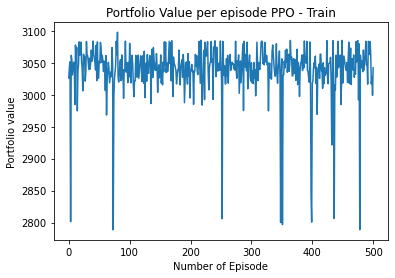

In [8]:
# 2000000
plt.plot(list_of_episodic_reward)
plt.title("Portfolio Value per episode PPO - Train")
plt.xlabel("Number of Episode")
plt.ylabel("Portfolio value")
plt.show()

## Testing PPO Implementation on the Environment



In [11]:
list_of_test_rewards = list()
number_test_episodes = 10
environment = StockTradingEnv()
for _ in range(number_test_episodes):
    episodic_reward = 0
    state = environment.reset()
    for _ in range(length_episodes):
        move = agent.movement_selection(state)
        state,rew,comp,_ = environment.step(move)
        episodic_reward += rew
        if comp == True:
            break
    list_of_test_rewards.append(environment.prev_port_val)
    agent.list_of_rewards,agent.actions,agent.states,agent.probability,agent.completed = list(),list(),list(),list(),list()


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.8/dist-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/usr/local/lib/python3.8/dist-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


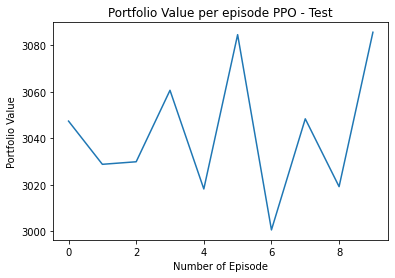

In [13]:
plt.plot(list_of_test_rewards)
plt.title("Portfolio Value per episode PPO - Test")
plt.xlabel("Number of Episode")
plt.ylabel("Portfolio Value")
plt.show()

In [14]:
np.mean(list_of_test_rewards)

3042.2952026182747